In [6]:
import h5py
import numpy as np
from chunkflow.chunk import Chunk
from dataset.local_shape_descriptor import get_local_shape_descriptors
from time import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
hf = h5py.File('./data/cremi/sample_A.hdf', 'r')
print('volA resolution:', hf['volumes']['raw'].attrs.get('resolution'))
hf = h5py.File('./data/cremi/sample_B.hdf', 'r')
print('volB resolution:', hf['volumes']['raw'].attrs.get('resolution'))
hf = h5py.File('./data/cremi/sample_C.hdf', 'r')
print('volC resolution:', hf['volumes']['raw'].attrs.get('resolution'))

volA resolution: [40.  4.  4.]
volB resolution: [40.  4.  4.]
volC resolution: [40.  4.  4.]


In [8]:
import matplotlib.pyplot as plt

def vis_lsd(lsd, i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,4)
    fig.set_size_inches(24, 6)
    lsd1 =  np.moveaxis(lsd[0:3, i ,: ,:],0,2)
    lsd2 =  np.moveaxis(lsd[3:6, i ,: ,:],0,2)
    lsd3 =  np.moveaxis(lsd[6:9, i ,: ,:],0,2)
    lsd4 =  lsd[9, i ,: ,:]
    axarr[0].imshow(lsd1)
    axarr[1].imshow(lsd2)
    axarr[2].imshow(lsd3)
    axarr[3].imshow(lsd4, cmap='jet')
    plt.show()


In [9]:


# resolution of each volume is [40nm, 4nm , 4nm]
# the sigma in the LSD is selected as 80nm or 120nm (pg. 20, 21)
# we choose sigma to be 120nm resulting in pixel values (3, 30, 30)
sigma = (3, 30, 30)
downsample = 2 # downsample factor of as in LSD paper (pg. 20)

Path = './data/cremi'
fileA = 'sample_A'
fileB = 'sample_B'
fileC = 'sample_C'

files = [fileA, fileB, fileC]

volumes = []
for file in files:
    print(f'Doing file {file}...')
    label = Chunk.from_h5(
        f'{Path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')

    # Segmentation shape (125, 1250, 1250) must be a multiple of downsampling factor 2 
    # so we append with a copy of last axial slice
    label = np.append(label, [label[-1]], axis=0)
    print(label.shape)

    lsd = get_local_shape_descriptors(label, sigma, downsample=downsample)
    print(f'lsd took {round(time()-ping, 4)} seconds.')
    print('lsd: ', lsd.shape)
    np.save(f'{Path}/{file}_lsd.npy',lsd)
    vis_lsd(lsd)

   


Doing file sample_A...
read from HDF5 file: ./data/cremi/sample_A.hdf


KeyboardInterrupt: 

In [10]:
from chunkflow.chunk import Chunk
from dataset.local_shape_descriptor import get_local_shape_descriptors

label = Chunk.from_h5(f'./data/cremi/sample_A.hdf', dataset_path='volumes/labels/neuron_ids')

read from HDF5 file: ./data/cremi/sample_A.hdf
global offset: None


100%|██████████| 330/330 [00:31<00:00, 10.56it/s]


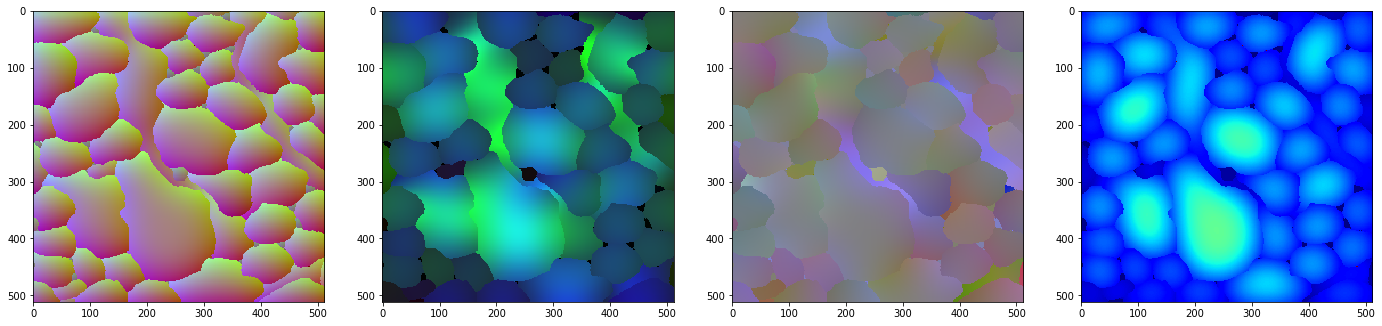

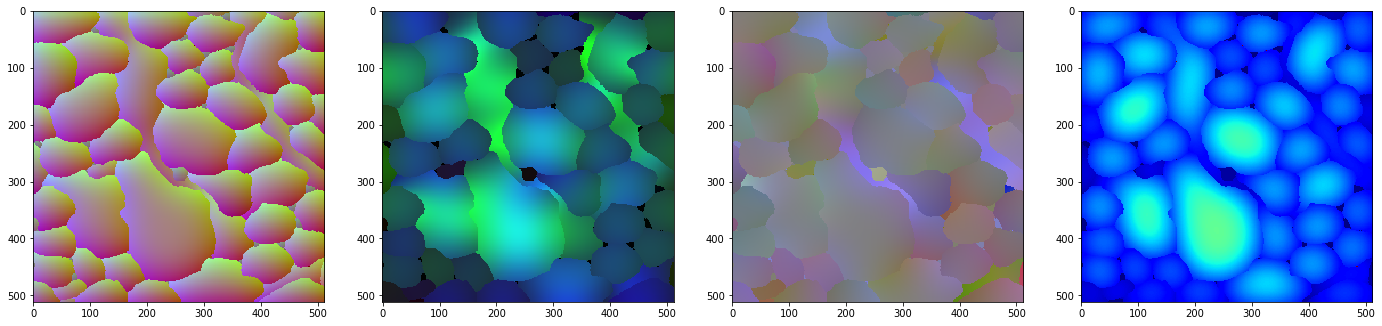

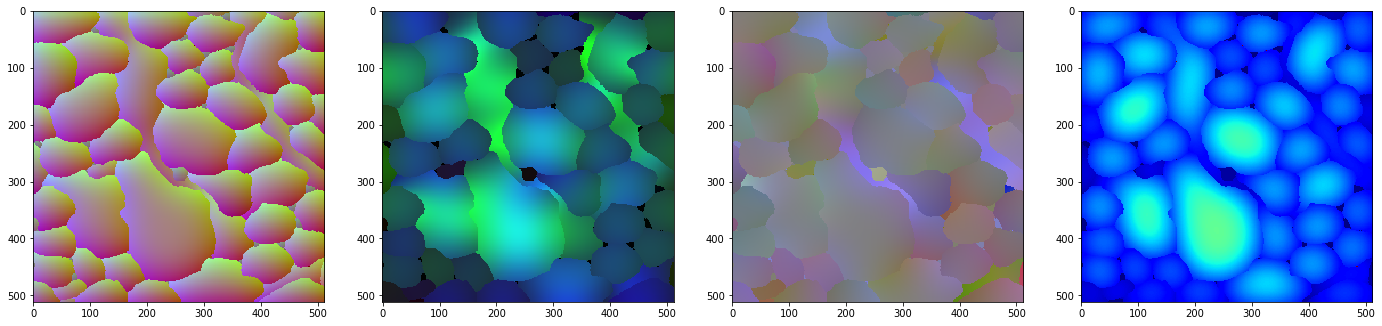

In [29]:
sigma = (3, 30, 30)
downsample = 2 # downsample factor of as in LSD paper (pg. 20)

sz = 512
label_chunk = label[0:4,0:sz,0:sz]
lsd_p2 = get_local_shape_descriptors(label_chunk, sigma, downsample=downsample, num_threads=2)
lsd_p4 = get_local_shape_descriptors(label_chunk, sigma, downsample=downsample, num_threads=4)
lsd_p8 = get_local_shape_descriptors(label_chunk, sigma, downsample=downsample, num_threads=8)

vis_lsd(lsd_p2)
vis_lsd(lsd_p4)
vis_lsd(lsd_p8)
